## Consumer Loan Default Prediction

The LendingClub loan dataset is available on Kaggle under the following link: https://www.kaggle.com/datasets/ethon0426/lending-club-20072020q1 <br>

The notebook consists of the following parts: <br>
1) Data preprocessing and feature selection
2) Logistic regression
3) XGBoost

In [1]:
# Import packages.
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt

from sklearn.feature_selection import f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from scipy.stats import chi2_contingency

pd.set_option('display.max_rows', 500)
pd.set_option('display.float_format', lambda x: '%.10f' % x)

In [2]:
# Load the dataset.
loan_src = pd.read_csv('C:/Loan_status_2007-2020Q3.gzip', low_memory=False)

In [3]:
loan_src.dtypes

Unnamed: 0                                      int64
id                                             object
loan_amnt                                     float64
funded_amnt                                   float64
funded_amnt_inv                               float64
term                                           object
int_rate                                       object
installment                                   float64
grade                                          object
sub_grade                                      object
emp_title                                      object
emp_length                                     object
home_ownership                                 object
annual_inc                                    float64
verification_status                            object
issue_d                                        object
loan_status                                    object
pymnt_plan                                     object
url                         

### Data preprocessing

Preprocessing consists of the following steps:

1) Non-numeric characters are removed.
2) The values are converted to numeric.
3) Missing values are filled using different values.
4) Categories are created for each feature and dummy variables are created.
5) Reference categories are removed.

The steps are slightly different depending on the feature. In particular datestamp features are converted into time difference in months until January 01, 2023 instead of numeric values.

In [4]:
def string_replace(loan_data):

    # Clean employment length values and convert to numeric.
    loan_data['emp_length_int'] = loan_data['emp_length'].str.replace('+ years', '')
    loan_data['emp_length_int'] = loan_data['emp_length_int'].str.replace('< 1 year', str(0))
    loan_data['emp_length_int'] = loan_data['emp_length_int'].str.replace('n/a',  str(0))
    loan_data['emp_length_int'] = loan_data['emp_length_int'].str.replace(' years', '')
    loan_data['emp_length_int'] = loan_data['emp_length_int'].str.replace(' year', '')
    loan_data['emp_length_int'] = pd.to_numeric(loan_data['emp_length_int'])

    # Clean interest rate values and convert to numeric.
    loan_data['int_rate'] = loan_data['int_rate'].str.replace('%', '')
    loan_data['int_rate'] = pd.to_numeric(loan_data['int_rate'])

    # Convert earliest credit line date values to datetime.
    loan_data['earliest_cr_line_date'] = pd.to_datetime(loan_data['earliest_cr_line'], format = '%b-%Y')

    # Calculate the time difference in months from the earliest credit line date to January, 01 2023.
    loan_data['mths_since_earliest_cr_line'] = round(pd.to_numeric((pd.to_datetime('2023-01-01') - loan_data['earliest_cr_line_date']) / np.timedelta64(1, 'M')))
    loan_data['mths_since_earliest_cr_line'][loan_data['mths_since_earliest_cr_line'] < 0] = loan_data['mths_since_earliest_cr_line'].max()

    # Clean loan term values and convert to numeric.
    loan_data['term_int'] = loan_data['term'].str.replace(' months', '')
    loan_data['term_int'] = pd.to_numeric(loan_data['term'].str.replace(' months', ''))

    # Convert issue date values to datetime and calculate time difference to January 01, 2023.
    loan_data['issue_d_date'] = pd.to_datetime(loan_data['issue_d'], format = '%b-%Y')
    loan_data['mths_since_issue_d'] = round(pd.to_numeric((pd.to_datetime('2023-01-01') - loan_data['issue_d_date']) / np.timedelta64(1, 'M')))

string_replace(loan_src)

C:\Users\harry\AppData\Local\Temp\ipykernel_2560\789022399.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_data['mths_since_earliest_cr_line'][loan_data['mths_since_earliest_cr_line'] < 0] = loan_data['mths_since_earliest_cr_line'].max()


In [5]:
# Fill missing values with mean values or zeros as needed.

def fill_missing(loan_data):
    loan_data['total_rev_hi_lim'].fillna(loan_data['funded_amnt'], inplace=True)
    loan_data['total_rev_hi_lim'].fillna(loan_data['total_rev_hi_lim'].mean(), inplace=True)
    loan_data['annual_inc'].fillna(loan_data['annual_inc'].mean(), inplace=True)
    loan_data['dti'].fillna(loan_data['dti'].mean(), inplace=True)
    loan_data['int_rate'].fillna(loan_data['int_rate'].mean(), inplace=True)
    loan_data['term_int'].fillna(loan_data['term_int'].min(), inplace=True)
    loan_data['mths_since_issue_d'].fillna(0, inplace=True)
    loan_data['mths_since_earliest_cr_line'].fillna(0, inplace=True)
    loan_data['mths_since_last_delinq'].fillna(0, inplace=True)
    loan_data['mths_since_last_record'].fillna(0, inplace=True)
    loan_data['acc_now_delinq'].fillna(0, inplace=True)
    loan_data['total_acc'].fillna(0, inplace=True)
    loan_data['pub_rec'].fillna(0, inplace=True)
    loan_data['open_acc'].fillna(0, inplace=True)
    loan_data['inq_last_6mths'].fillna(0, inplace=True)
    loan_data['delinq_2yrs'].fillna(0, inplace=True)
    loan_data['emp_length_int'].fillna(0, inplace=True)

fill_missing(loan_src)

The definition of a bad loan in the ground truth includes the following categories:<br><br>
-'Charged Off'<br>
-'Default'<br>
-'Does not meet the credit policy. Status:Charged Off'<br>
-'Late (31-120 days)'<br>

In [6]:
# Create new binary ground truth label.
loan_src = loan_src.copy()
loan_src['good_bad'] = np.where(loan_src['loan_status'].isin(['Charged Off', 'Default',
                                                       'Does not meet the credit policy. Status:Charged Off',
                                                       'Late (31-120 days)']), 0, 1)


In [7]:

y_train = loan_src['good_bad']
loan_src.drop('good_bad', inplace = True, axis=1)
X_train_cat = loan_src.select_dtypes(include = 'object').copy()
X_train_num = loan_src.select_dtypes(include = 'number').copy()


# Chi-squared test.
chi2_check = {}

for column in X_train_cat:
    chi, p, dof, ex = chi2_contingency(pd.crosstab(y_train, X_train_cat[column]))
    chi2_check.setdefault('Feature',[]).append(column)
    chi2_check.setdefault('p-value',[]).append(round(p,10))

chi2_result = pd.DataFrame(data = chi2_check)
chi2_result.sort_values(by = ['p-value'], ascending = True, ignore_index = True, inplace = True)
chi2_result

,Feature,p-value
0,earliest_cr_line,0.0000000000
1,payment_plan_start_date,0.0000000000
2,hardship_end_date,0.0000000000
3,hardship_start_date,0.0000000000
4,hardship_status,0.0000000000
5,hardship_reason,0.0000000000
6,hardship_type,0.0000000000
7,hardship_flag,0.0000000000
8,sec_app_earliest_cr_line,0.0000000000
9,verification_status_joint,0.0000000000


In [8]:
# ANOVA.
X_train_num.fillna(X_train_num.mean(), inplace=True)
f_stat, p_val = f_classif(X_train_num, y_train)
ANOVA_tab = pd.DataFrame(data = {'Numerical_Feature': X_train_num.columns.values, 'F-score': f_stat, 'p-values': p_val.round(decimals=10)})
ANOVA_tab.sort_values(by = ['F-score'], ascending = False, ignore_index = True, inplace = True)
ANOVA_tab

c:\Users\harry\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\harry\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


,Numerical_Feature,F-score,p-values
0,last_fico_range_high,1754201.0241874896,0.0000000000
1,last_fico_range_low,1336299.5088848195,0.0000000000
2,recoveries,1088759.2345701300,0.0000000000
3,collection_recovery_fee,990867.6596744618,0.0000000000
4,total_rec_prncp,169740.6129720267,0.0000000000
5,int_rate,129338.6735453715,0.0000000000
6,last_pymnt_amnt,109359.9896432763,0.0000000000
7,out_prncp,101115.2799328276,0.0000000000
8,out_prncp_inv,101100.3986945935,0.0000000000
9,mths_since_issue_d,62724.6575147454,0.0000000000


<Axes: >

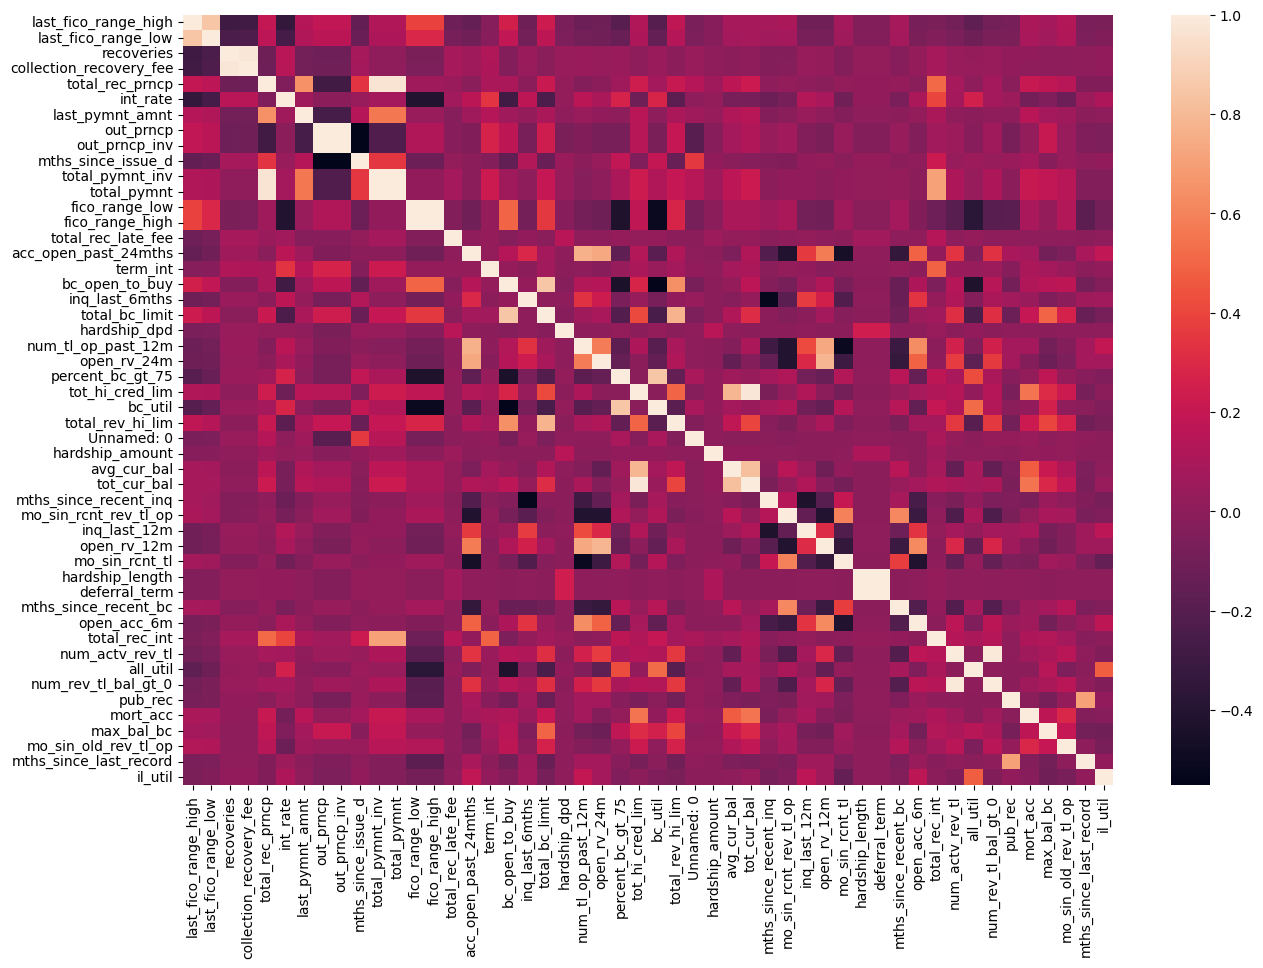

In [9]:
top_features_ANOVA = ANOVA_tab.iloc[:50,0].to_list()
corr = X_train_num[top_features_ANOVA].corr()
plt.figure(figsize=(15,10))
sns.heatmap(corr)

In [10]:
# function to create dummy variables
def dummy_creation(df, columns_list):
    df_dummies = []
    for col in columns_list:
        df_dummies.append(pd.get_dummies(df[col], prefix = col, prefix_sep = ':'))
    df_dummies = pd.concat(df_dummies, axis = 1)
    df = pd.concat([df, df_dummies], axis = 1)
    return df

# apply to our final four categorical variables
loan_src = dummy_creation(loan_src, ['grade', 'sub_grade','home_ownership', 'verification_status','loan_status', 'purpose', 'addr_state', 'initial_list_status'])

In [11]:
def create_categorical(loan_data):
    # Create categories for term feature.
    loan_data['term:36'] = np.where((loan_data['term_int'] == 36), 1, 0)
    loan_data['term:60'] = np.where((loan_data['term_int'] == 60), 1, 0)

    # Create categories for employment length feature.
    loan_data['emp_length:0'] = np.where(loan_data['emp_length_int'].isin([0]), 1, 0)
    loan_data['emp_length:1'] = np.where(loan_data['emp_length_int'].isin([1]), 1, 0)
    loan_data['emp_length:2-4'] = np.where(loan_data['emp_length_int'].isin(range(2, 5)), 1, 0)
    loan_data['emp_length:5-6'] = np.where(loan_data['emp_length_int'].isin(range(5, 7)), 1, 0)
    loan_data['emp_length:7-9'] = np.where(loan_data['emp_length_int'].isin(range(7, 10)), 1, 0)
    loan_data['emp_length:10'] = np.where(loan_data['emp_length_int'].isin([10]), 1, 0)

    # Create categories for months since issue date feature.
    loan_data['mths_since_issue_d:less than 38'] = np.where(loan_data['mths_since_issue_d'].isin(range(38)), 1, 0)
    loan_data['mths_since_issue_d:38-39'] = np.where(loan_data['mths_since_issue_d'].isin(range(38, 40)), 1, 0)
    loan_data['mths_since_issue_d:40-41'] = np.where(loan_data['mths_since_issue_d'].isin(range(40, 42)), 1, 0)
    loan_data['mths_since_issue_d:42-48'] = np.where(loan_data['mths_since_issue_d'].isin(range(42, 49)), 1, 0)
    loan_data['mths_since_issue_d:49-52'] = np.where(loan_data['mths_since_issue_d'].isin(range(49, 53)), 1, 0)
    loan_data['mths_since_issue_d:53-64'] = np.where(loan_data['mths_since_issue_d'].isin(range(53, 65)), 1, 0)
    loan_data['mths_since_issue_d:65-84'] = np.where(loan_data['mths_since_issue_d'].isin(range(65, 85)), 1, 0)
    loan_data['mths_since_issue_d:>84'] = np.where(loan_data['mths_since_issue_d'].isin(range(85, int(loan_data['mths_since_issue_d'].max()))), 1, 0)

    # Create categories for interest rate feature.
    loan_data['int_rate:less than 9.548'] = np.where((loan_data['int_rate'] <= 9.548), 1, 0)
    loan_data['int_rate:9.548-12.025'] = np.where((loan_data['int_rate'] > 9.548) & (loan_data['int_rate'] <= 12.025), 1, 0)
    loan_data['int_rate:12.025-15.74'] = np.where((loan_data['int_rate'] > 12.025) & (loan_data['int_rate'] <= 15.74), 1, 0)
    loan_data['int_rate:15.74-20.281'] = np.where((loan_data['int_rate'] > 15.74) & (loan_data['int_rate'] <= 20.281), 1, 0)
    loan_data['int_rate:>20.281'] = np.where((loan_data['int_rate'] > 20.281), 1, 0)

    # Create categories for months since earliest credit line feature.
    loan_data['mths_since_earliest_cr_line:less than 140'] = np.where(loan_data['mths_since_earliest_cr_line'].isin(range(140)), 1, 0)
    loan_data['mths_since_earliest_cr_line:141-164'] = np.where(loan_data['mths_since_earliest_cr_line'].isin(range(140, 165)), 1, 0)
    loan_data['mths_since_earliest_cr_line:165-247'] = np.where(loan_data['mths_since_earliest_cr_line'].isin(range(165, 248)), 1, 0)
    loan_data['mths_since_earliest_cr_line:248-270'] = np.where(loan_data['mths_since_earliest_cr_line'].isin(range(248, 271)), 1, 0)
    loan_data['mths_since_earliest_cr_line:271-352'] = np.where(loan_data['mths_since_earliest_cr_line'].isin(range(271, 353)), 1, 0)
    loan_data['mths_since_earliest_cr_line:>352'] = np.where(loan_data['mths_since_earliest_cr_line'].isin(range(353, int(loan_data['mths_since_earliest_cr_line'].max()))), 1, 0)

    # Create categories for delinquencies in past 2 years feature.
    loan_data['delinq_2yrs:0'] = np.where((loan_data['delinq_2yrs'] == 0), 1, 0)
    loan_data['delinq_2yrs:1-3'] = np.where((loan_data['delinq_2yrs'] >= 1) & (loan_data['delinq_2yrs'] <= 3), 1, 0)
    loan_data['delinq_2yrs:>=4'] = np.where((loan_data['delinq_2yrs'] >= 9), 1, 0)

    # Create categories for inquiries in last 6 months feature.
    loan_data['inq_last_6mths:0'] = np.where((loan_data['inq_last_6mths'] == 0), 1, 0)
    loan_data['inq_last_6mths:1-2'] = np.where((loan_data['inq_last_6mths'] >= 1) & (loan_data['inq_last_6mths'] <= 2), 1, 0)
    loan_data['inq_last_6mths:3-6'] = np.where((loan_data['inq_last_6mths'] >= 3) & (loan_data['inq_last_6mths'] <= 6), 1, 0)
    loan_data['inq_last_6mths:>6'] = np.where((loan_data['inq_last_6mths'] > 6), 1, 0)

    # Create categories for open accounts feature.
    loan_data['open_acc:0'] = np.where((loan_data['open_acc'] == 0), 1, 0)
    loan_data['open_acc:1-3'] = np.where((loan_data['open_acc'] >= 1) & (loan_data['open_acc'] <= 3), 1, 0)
    loan_data['open_acc:4-12'] = np.where((loan_data['open_acc'] >= 4) & (loan_data['open_acc'] <= 12), 1, 0)
    loan_data['open_acc:13-17'] = np.where((loan_data['open_acc'] >= 13) & (loan_data['open_acc'] <= 17), 1, 0)
    loan_data['open_acc:18-22'] = np.where((loan_data['open_acc'] >= 18) & (loan_data['open_acc'] <= 22), 1, 0)
    loan_data['open_acc:23-25'] = np.where((loan_data['open_acc'] >= 23) & (loan_data['open_acc'] <= 25), 1, 0)
    loan_data['open_acc:26-30'] = np.where((loan_data['open_acc'] >= 26) & (loan_data['open_acc'] <= 30), 1, 0)
    loan_data['open_acc:>=31'] = np.where((loan_data['open_acc'] >= 31), 1, 0)

    # Create categories for derogatory public records feature.
    loan_data['pub_rec:0-2'] = np.where((loan_data['pub_rec'] >= 0) & (loan_data['pub_rec'] <= 2), 1, 0)
    loan_data['pub_rec:3-4'] = np.where((loan_data['pub_rec'] >= 3) & (loan_data['pub_rec'] <= 4), 1, 0)
    loan_data['pub_rec:>=5'] = np.where((loan_data['pub_rec'] >= 5), 1, 0)

    # Create categories for total accounts in borrower's credit file feature.
    loan_data['total_acc:less than 27'] = np.where((loan_data['total_acc'] <= 27), 1, 0)
    loan_data['total_acc:28-51'] = np.where((loan_data['total_acc'] >= 28) & (loan_data['total_acc'] <= 51), 1, 0)
    loan_data['total_acc:>=52'] = np.where((loan_data['total_acc'] >= 52), 1, 0)

    # Create categories for delinquent accounts feature.
    loan_data['acc_now_delinq:0'] = np.where((loan_data['acc_now_delinq'] == 0), 1, 0)
    loan_data['acc_now_delinq:>=1'] = np.where((loan_data['acc_now_delinq'] >= 1), 1, 0)

    # Create categories for total revolving credit limit feature.
    loan_data['total_rev_hi_lim:less than 5K'] = np.where((loan_data['total_rev_hi_lim'] <= 5000), 1, 0)
    loan_data['total_rev_hi_lim:5K-10K'] = np.where((loan_data['total_rev_hi_lim'] > 5000) & (loan_data['total_rev_hi_lim'] <= 10000), 1, 0)
    loan_data['total_rev_hi_lim:10K-20K'] = np.where((loan_data['total_rev_hi_lim'] > 10000) & (loan_data['total_rev_hi_lim'] <= 20000), 1, 0)
    loan_data['total_rev_hi_lim:20K-30K'] = np.where((loan_data['total_rev_hi_lim'] > 20000) & (loan_data['total_rev_hi_lim'] <= 30000), 1, 0)
    loan_data['total_rev_hi_lim:30K-40K'] = np.where((loan_data['total_rev_hi_lim'] > 30000) & (loan_data['total_rev_hi_lim'] <= 40000), 1, 0)
    loan_data['total_rev_hi_lim:40K-55K'] = np.where((loan_data['total_rev_hi_lim'] > 40000) & (loan_data['total_rev_hi_lim'] <= 55000), 1, 0)
    loan_data['total_rev_hi_lim:55K-95K'] = np.where((loan_data['total_rev_hi_lim'] > 55000) & (loan_data['total_rev_hi_lim'] <= 95000), 1, 0)
    loan_data['total_rev_hi_lim:>95K'] = np.where((loan_data['total_rev_hi_lim'] > 95000), 1, 0)

    # Create categories for annual income feature.
    loan_data['annual_inc:less than 20K'] = np.where((loan_data['annual_inc'] <= 20000), 1, 0)
    loan_data['annual_inc:20K-30K'] = np.where((loan_data['annual_inc'] > 20000) & (loan_data['annual_inc'] <= 30000), 1, 0)
    loan_data['annual_inc:30K-40K'] = np.where((loan_data['annual_inc'] > 30000) & (loan_data['annual_inc'] <= 40000), 1, 0)
    loan_data['annual_inc:40K-50K'] = np.where((loan_data['annual_inc'] > 40000) & (loan_data['annual_inc'] <= 50000), 1, 0)
    loan_data['annual_inc:50K-60K'] = np.where((loan_data['annual_inc'] > 50000) & (loan_data['annual_inc'] <= 60000), 1, 0)
    loan_data['annual_inc:60K-70K'] = np.where((loan_data['annual_inc'] > 60000) & (loan_data['annual_inc'] <= 70000), 1, 0)
    loan_data['annual_inc:70K-80K'] = np.where((loan_data['annual_inc'] > 70000) & (loan_data['annual_inc'] <= 80000), 1, 0)
    loan_data['annual_inc:80K-90K'] = np.where((loan_data['annual_inc'] > 80000) & (loan_data['annual_inc'] <= 90000), 1, 0)
    loan_data['annual_inc:90K-100K'] = np.where((loan_data['annual_inc'] > 90000) & (loan_data['annual_inc'] <= 100000), 1, 0)
    loan_data['annual_inc:100K-120K'] = np.where((loan_data['annual_inc'] > 100000) & (loan_data['annual_inc'] <= 120000), 1, 0)
    loan_data['annual_inc:120K-140K'] = np.where((loan_data['annual_inc'] > 120000) & (loan_data['annual_inc'] <= 140000), 1, 0)
    loan_data['annual_inc:>140K'] = np.where((loan_data['annual_inc'] > 140000), 1, 0)

    # Create categories for months since last delinquency feature.
    loan_data['mths_since_last_delinq:Missing'] = np.where((loan_data['mths_since_last_delinq'].isnull()), 1, 0)
    loan_data['mths_since_last_delinq:0-3'] = np.where((loan_data['mths_since_last_delinq'] >= 0) & (loan_data['mths_since_last_delinq'] <= 3), 1, 0)
    loan_data['mths_since_last_delinq:4-30'] = np.where((loan_data['mths_since_last_delinq'] >= 4) & (loan_data['mths_since_last_delinq'] <= 30), 1, 0)
    loan_data['mths_since_last_delinq:31-56'] = np.where((loan_data['mths_since_last_delinq'] >= 31) & (loan_data['mths_since_last_delinq'] <= 56), 1, 0)
    loan_data['mths_since_last_delinq:>=57'] = np.where((loan_data['mths_since_last_delinq'] >= 57), 1, 0)

    # Create categories for debt-to-income feature.
    loan_data['dti:less than 1.4'] = np.where((loan_data['dti'] <= 1.4), 1, 0)
    loan_data['dti:1.4-3.5'] = np.where((loan_data['dti'] > 1.4) & (loan_data['dti'] <= 3.5), 1, 0)
    loan_data['dti:3.5-7.7'] = np.where((loan_data['dti'] > 3.5) & (loan_data['dti'] <= 7.7), 1, 0)
    loan_data['dti:7.7-10.5'] = np.where((loan_data['dti'] > 7.7) & (loan_data['dti'] <= 10.5), 1, 0)
    loan_data['dti:10.5-16.1'] = np.where((loan_data['dti'] > 10.5) & (loan_data['dti'] <= 16.1), 1, 0)
    loan_data['dti:16.1-20.3'] = np.where((loan_data['dti'] > 16.1) & (loan_data['dti'] <= 20.3), 1, 0)
    loan_data['dti:20.3-21.7'] = np.where((loan_data['dti'] > 20.3) & (loan_data['dti'] <= 21.7), 1, 0)
    loan_data['dti:21.7-22.4'] = np.where((loan_data['dti'] > 21.7) & (loan_data['dti'] <= 22.4), 1, 0)
    loan_data['dti:22.4-35'] = np.where((loan_data['dti'] > 22.4) & (loan_data['dti'] <= 35), 1, 0)
    loan_data['dti:>35'] = np.where((loan_data['dti'] > 35), 1, 0)

    # Create categories for months since last public record feature.
    loan_data['mths_since_last_record:Missing'] = np.where((loan_data['mths_since_last_record'].isnull()), 1, 0)
    loan_data['mths_since_last_record:0-2'] = np.where((loan_data['mths_since_last_record'] >= 0) & (loan_data['mths_since_last_record'] <= 2), 1, 0)
    loan_data['mths_since_last_record:3-20'] = np.where((loan_data['mths_since_last_record'] >= 3) & (loan_data['mths_since_last_record'] <= 20), 1, 0)
    loan_data['mths_since_last_record:21-31'] = np.where((loan_data['mths_since_last_record'] >= 21) & (loan_data['mths_since_last_record'] <= 31), 1, 0)
    loan_data['mths_since_last_record:32-80'] = np.where((loan_data['mths_since_last_record'] >= 32) & (loan_data['mths_since_last_record'] <= 80), 1, 0)
    loan_data['mths_since_last_record:81-86'] = np.where((loan_data['mths_since_last_record'] >= 81) & (loan_data['mths_since_last_record'] <= 86), 1, 0)
    loan_data['mths_since_last_record:>86'] = np.where((loan_data['mths_since_last_record'] > 86), 1, 0)

create_categorical(loan_src)

C:\Users\harry\AppData\Local\Temp\ipykernel_2560\3915104518.py:121: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  loan_data['mths_since_last_record:21-31'] = np.where((loan_data['mths_since_last_record'] >= 21) & (loan_data['mths_since_last_record'] <= 31), 1, 0)
C:\Users\harry\AppData\Local\Temp\ipykernel_2560\3915104518.py:122: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  loan_data['mths_since_last_record:32-80'] = np.where((loan_data['mths_since_last_record'] >= 32) & (loan_data['mths_since_last_record'] <= 80), 1, 0)
C:\Use

In [12]:
# This is the full set of features to be used.
input_data = loan_src.loc[: , 
['grade:A',
'grade:B',
'grade:C',
'grade:D',
'grade:E',
'grade:F',
'grade:G',
'home_ownership:ANY',
'home_ownership:MORTGAGE',
'home_ownership:NONE',
'home_ownership:OTHER',
'home_ownership:OWN',
'home_ownership:RENT',
'addr_state:AK',
'addr_state:AL',
'addr_state:AR',
'addr_state:AZ',
'addr_state:CA',
'addr_state:CO',
'addr_state:CT',
'addr_state:DC',
'addr_state:DE',
'addr_state:FL',
'addr_state:GA',
'addr_state:HI',
'addr_state:IA',
'addr_state:ID',
'addr_state:IL',
'addr_state:IN',
'addr_state:KS',
'addr_state:KY',
'addr_state:LA',
'addr_state:MA',
'addr_state:MD',
'addr_state:ME',
'addr_state:MI',
'addr_state:MN',
'addr_state:MO',
'addr_state:MS',
'addr_state:MT',
'addr_state:NC',
'addr_state:ND',
'addr_state:NE',
'addr_state:NH',
'addr_state:NJ',
'addr_state:NM',
'addr_state:NV',
'addr_state:NY',
'addr_state:OH',
'addr_state:OK',
'addr_state:OR',
'addr_state:PA',
'addr_state:RI',
'addr_state:SC',
'addr_state:SD',
'addr_state:TN',
'addr_state:TX',
'addr_state:UT',
'addr_state:VA',
'addr_state:VT',
'addr_state:WA',
'addr_state:WI',
'addr_state:WV',
'addr_state:WY',
'verification_status:Not Verified',
'verification_status:Source Verified',
'verification_status:Verified',
'purpose:car',
'purpose:credit_card',
'purpose:debt_consolidation',
'purpose:educational',
'purpose:home_improvement',
'purpose:house',
'purpose:major_purchase',
'purpose:medical',
'purpose:moving',
'purpose:other',
'purpose:renewable_energy',
'purpose:small_business',
'purpose:vacation',
'purpose:wedding',
'initial_list_status:f',
'initial_list_status:w',
'term:36',
'term:60',
'emp_length:0',
'emp_length:1',
'emp_length:2-4',
'emp_length:5-6',
'emp_length:7-9',
'emp_length:10',
'mths_since_issue_d:less than 38',
'mths_since_issue_d:38-39',
'mths_since_issue_d:40-41',
'mths_since_issue_d:42-48',
'mths_since_issue_d:49-52',
'mths_since_issue_d:53-64',
'mths_since_issue_d:65-84',
'mths_since_issue_d:>84',
'int_rate:less than 9.548',
'int_rate:9.548-12.025',
'int_rate:12.025-15.74',
'int_rate:15.74-20.281',
'int_rate:>20.281',
'mths_since_earliest_cr_line:less than 140',
'mths_since_earliest_cr_line:141-164',
'mths_since_earliest_cr_line:165-247',
'mths_since_earliest_cr_line:248-270',
'mths_since_earliest_cr_line:271-352',
'mths_since_earliest_cr_line:>352',
'inq_last_6mths:0',
'inq_last_6mths:1-2',
'inq_last_6mths:3-6',
'inq_last_6mths:>6',
'acc_now_delinq:0',
'acc_now_delinq:>=1',
'annual_inc:less than 20K',
'annual_inc:20K-30K',
'annual_inc:30K-40K',
'annual_inc:40K-50K',
'annual_inc:50K-60K',
'annual_inc:60K-70K',
'annual_inc:70K-80K',
'annual_inc:80K-90K',
'annual_inc:90K-100K',
'annual_inc:100K-120K',
'annual_inc:120K-140K',
'annual_inc:>140K',
'dti:less than 1.4',
'dti:1.4-3.5',
'dti:3.5-7.7',
'dti:7.7-10.5',
'dti:10.5-16.1',
'dti:16.1-20.3',
'dti:20.3-21.7',
'dti:21.7-22.4',
'dti:22.4-35',
'dti:>35',
'mths_since_last_delinq:Missing',
'mths_since_last_delinq:0-3',
'mths_since_last_delinq:4-30',
'mths_since_last_delinq:31-56',
'mths_since_last_delinq:>=57',
'mths_since_last_record:Missing',
'mths_since_last_record:0-2',
'mths_since_last_record:3-20',
'mths_since_last_record:21-31',
'mths_since_last_record:32-80',
'mths_since_last_record:81-86',
'mths_since_last_record:>86'
]]

In [13]:
# This is the list of reference categories for the dummy variables which are dropped from the dataset.
ref_categories = ['grade:G',
'home_ownership:ANY',
'addr_state:AK',
'verification_status:Verified',
'purpose:car',
'initial_list_status:f',
'term:60',
'emp_length:0',
'mths_since_issue_d:>84',
'int_rate:>20.281',
'mths_since_earliest_cr_line:less than 140',
'inq_last_6mths:>6',
'acc_now_delinq:0',
'annual_inc:less than 20K',
'dti:>35',
'mths_since_last_delinq:0-3',
'mths_since_last_record:0-2']

In [14]:
# Drop reference categories.
input_data = input_data.drop(ref_categories, axis = 1)

### Train / Validation / Test split

The dataset is split into 60% training , 20% validation and 20% test sets. We use sklearn's train_test_split function which is used twice.

In [15]:
# Split 60/20/20 into training, validation and test sets.
X_train, X_test, y_train, y_test = train_test_split(input_data, y_train, test_size = 0.2, random_state = 42)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42) # 0.25 x 0.8 = 0.2

kfold = StratifiedKFold(n_splits=10)

### Logistic regression model
In this section, a logistic regression model is fitted and evaluated.

In [16]:
logreg = LogisticRegression(max_iter=1000)
output = cross_val_score(logreg, X_train, y_train, scoring = 'roc_auc', cv = kfold)

AUROC = np.mean(output)
GINI = AUROC * 2 - 1

# print the mean AUROC score and Gini
print('Mean AUROC: %.4f' % (AUROC))
print('Gini: %.4f' % (GINI))

logreg.fit(X_train, y_train)

Mean AUROC: 0.7483
Gini: 0.4967


LogisticRegression(max_iter=1000)

In [17]:
# Create summary table with the coefficients for each feature.
feature_name = X_train.columns.values
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
summary_table['Coefficients'] = np.transpose(logreg.coef_)
summary_table.index = summary_table.index + 1
summary_table.loc[0] = ['Intercept', logreg.intercept_[0]]
summary_table = summary_table.sort_index()

In [18]:
# Display features ordered by coefficients.
print(summary_table.sort_values('Coefficients', ascending=False))

                            Feature name  Coefficients
84       mths_since_issue_d:less than 38  3.3054739695
85              mths_since_issue_d:38-39  2.1320368223
1                                grade:A  1.7252893884
86              mths_since_issue_d:40-41  1.6991605380
2                                grade:B  1.2299684303
87              mths_since_issue_d:42-48  1.0290693981
3                                grade:C  0.8687095440
100                     inq_last_6mths:0  0.7039637493
88              mths_since_issue_d:49-52  0.6384616565
4                                grade:D  0.5923811783
32                         addr_state:ME  0.5665358497
101                   inq_last_6mths:1-2  0.5140002395
57                         addr_state:VT  0.4528337413
91              int_rate:less than 9.548  0.4383426468
102                   inq_last_6mths:3-6  0.3595060373
5                                grade:E  0.3526402575
60                         addr_state:WV  0.2988117419
48        

In [19]:
# Predict the test labels with the logistic regression.
y_hat_test_proba = logreg.predict_proba(X_test)
y_hat_test_proba = y_hat_test_proba[: ][: , 1]
y_test.reset_index(drop = True, inplace = True)
df_actual_predicted_probs = pd.concat([y_test, pd.DataFrame(y_hat_test_proba)], axis = 1)
df_actual_predicted_probs.columns = ['y_test', 'y_hat_test_proba']
df_actual_predicted_probs.index = X_test.index

# Predictions above threshold are considered 1, else 0.
tr = 0.9
df_actual_predicted_probs['y_hat_test'] = np.where(df_actual_predicted_probs['y_hat_test_proba'] > tr, 1, 0)

In [20]:
# Calculate accuracy.
acc = (pd.crosstab(df_actual_predicted_probs['y_test'], df_actual_predicted_probs['y_hat_test'], rownames = ['Actual'], colnames = ['Predicted']) / df_actual_predicted_probs.shape[0]).iloc[0, 0] + (pd.crosstab(df_actual_predicted_probs['y_test'], df_actual_predicted_probs['y_hat_test'], rownames = ['Actual'], colnames = ['Predicted']) / df_actual_predicted_probs.shape[0]).iloc[1, 1]
print (f"The logistic regression accuracy is {acc*100:.2f}%")

The logistic regression accuracy is 55.45%


Text(0.5, 1.0, 'ROC curve')

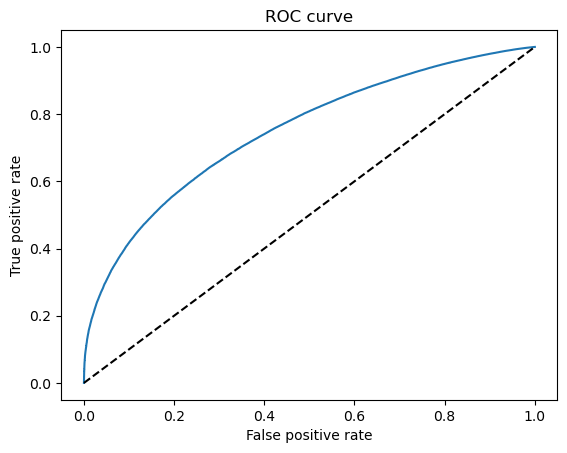

In [21]:
# Plot the ROC curve.
fpr, tpr, thresholds = roc_curve(df_actual_predicted_probs['y_test'], df_actual_predicted_probs['y_hat_test_proba'])
plt.plot(fpr, tpr)
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')

In [22]:
# Calculate the AUROC metric.
AUROC = roc_auc_score(df_actual_predicted_probs['y_test'], df_actual_predicted_probs['y_hat_test_proba'])
print (f"The logistic regression AUROC score is {AUROC:.2f}")

The logistic regression AUROC score is 0.75


Text(0.5, 1.0, 'Kolmogorov-Smirnov')

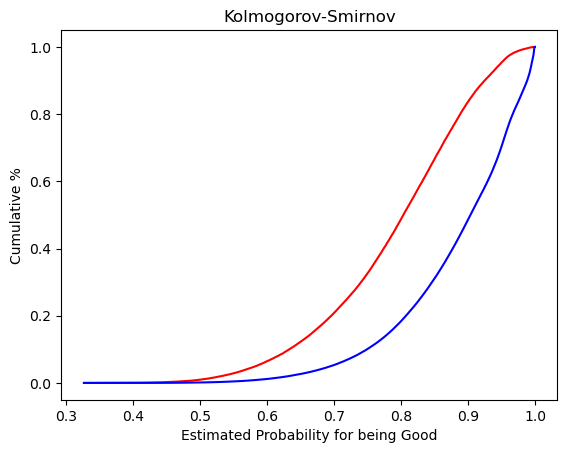

In [23]:
# Calculate the Kolmogorov-Smirnov (KS) statistics.
df_actual_predicted_probs = df_actual_predicted_probs.sort_values('y_hat_test_proba')
df_actual_predicted_probs = df_actual_predicted_probs.reset_index()
df_actual_predicted_probs['Cumulative N Population'] = df_actual_predicted_probs.index + 1
df_actual_predicted_probs['Cumulative N Good'] = df_actual_predicted_probs['y_test'].cumsum()
df_actual_predicted_probs['Cumulative N Bad'] = df_actual_predicted_probs['Cumulative N Population'] - df_actual_predicted_probs['y_test'].cumsum()
df_actual_predicted_probs['Cumulative Perc Population'] = df_actual_predicted_probs['Cumulative N Population'] / (df_actual_predicted_probs.shape[0])
df_actual_predicted_probs['Cumulative Perc Good'] = df_actual_predicted_probs['Cumulative N Good'] / df_actual_predicted_probs['y_test'].sum()
df_actual_predicted_probs['Cumulative Perc Bad'] = df_actual_predicted_probs['Cumulative N Bad'] / (df_actual_predicted_probs.shape[0] - df_actual_predicted_probs['y_test'].sum())

# Plot KS.
plt.plot(df_actual_predicted_probs['y_hat_test_proba'], df_actual_predicted_probs['Cumulative Perc Bad'], color = 'r')
plt.plot(df_actual_predicted_probs['y_hat_test_proba'], df_actual_predicted_probs['Cumulative Perc Good'], color = 'b')
plt.xlabel('Estimated Probability for being Good')
plt.ylabel('Cumulative %')
plt.title('Kolmogorov-Smirnov')

In [24]:
# Calculate the KS score.
KS = max(df_actual_predicted_probs['Cumulative Perc Bad'] - df_actual_predicted_probs['Cumulative Perc Good'])
print (f"The logistic regression K-S score is {KS:.2f}")

The logistic regression K-S score is 0.36


### XGBoost model
In this section, the gradient boosting model XGBoost is trained and evaluated. 

In [29]:
# Convert the datasets into DMatrix format.
dtrain = xgb.DMatrix(X_train, y_train.values)
#dval = xgb.DMatrix(X_val, y_val.values)
dtest = xgb.DMatrix(X_test, y_test.values)

# Set hyperparameters.
params = {
    'objective':'binary:logistic',
    'eta': 0.1,
    'gamma': 0,
    'max_depth': 4,
    'min_child_weight': 1,
    'max_delta_step': 0,
    'subsample': 0.5,
    'colsample_bytree': 0.9,
    'eval_metric': 'auc',
    'random_state': 42
}

# Train the model.
model = xgb.train(params, 
                dtrain=dtrain,
                evals=[(dtrain,'train'),(dtest,'test')],
                num_boost_round=1000,
                early_stopping_rounds=10,
                verbose_eval=100) 


[0]	train-auc:0.70381	test-auc:0.70396
[100]	train-auc:0.74719	test-auc:0.74679
[200]	train-auc:0.75030	test-auc:0.74913
[300]	train-auc:0.75180	test-auc:0.75007
[400]	train-auc:0.75287	test-auc:0.75061
[500]	train-auc:0.75372	test-auc:0.75100
[600]	train-auc:0.75445	test-auc:0.75122
[700]	train-auc:0.75509	test-auc:0.75144
[719]	train-auc:0.75519	test-auc:0.75144


In [ ]:
# Calculate and display feature importance.
fig, (ax) = plt.subplots(ncols=1, figsize=(15,30))
xgb.plot_importance(model, height=5, title="Features importance (XGBoost)", ax=ax, color="green") 
plt.show()

In [ ]:
# Calculate AUROC score for XGBoost.
preds = model.predict(dtest)
score = roc_auc_score(y_test.values, preds)
print (f"The XGBoost AUROC score is {score:.2f}")

### Conclusion:
Both models perform at a similar level with same AUROC scores of 0.75. For the logistic regression, the 5 features with the highest coefficients include "Months since issue date" and "Grade". For XGBoost, the 5 most important features include "Term" and "Months since issue date" and "Home ownership".